In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2024-07-13 00:18:04.070444: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-13 00:18:04.767773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
val_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [5]:
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 5)
val_batches = val_dataset.skip(val_batches // 5)

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
])

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [2]:
# IMG_SHAAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet')
print(len(list(base_model.layers)))
# image_batch, label_batch = next(iter(train_dataset))
# feature_batch = base_model(image_batch)
# 
# print(feature_batch.shape)

/tmp/ipykernel_6761/1747354469.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet')
2024-07-13 00:18:25.276526: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 00:18:25.539072: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 00:18:25.539128: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-1

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
154


In [9]:
base_model.trainable = False

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [11]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [12]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
base_learning_rate = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [14]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
initial_epochs = 10
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=val_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 336ms/step - accuracy: 0.6575 - loss: 0.6311 - val_accuracy: 0.9470 - val_loss: 0.1411
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - accuracy: 0.8720 - loss: 0.2785 - val_accuracy: 0.9610 - val_loss: 0.1049
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 291ms/step - accuracy: 0.9015 - loss: 0.2255 - val_accuracy: 0.9640 - val_loss: 0.0937
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - accuracy: 0.9139 - loss: 0.2076 - val_accuracy: 0.9690 - val_loss: 0.0822
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 282ms/step - accuracy: 0.9111 - loss: 0.1804 - val_accuracy: 0.9720 - val_loss: 0.0748
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 281ms/step - accuracy: 0.9138 - loss: 0.1953 - val_accuracy: 0.9740 - val_loss: 0.0729
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 282ms/step - accuracy: 0.9240 - loss: 0.1685 - val_accuracy: 0.9680 - val_loss: 0.0755
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 283ms/step - accuracy: 0.9255 - loss: 0.1757 - val_accu

In [16]:
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [18]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 429ms/step - accuracy: 0.8922 - loss: 0.2796 - val_accuracy: 0.9720 - val_loss: 0.0610
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 417ms/step - accuracy: 0.9372 - loss: 0.1584 - val_accuracy: 0.9730 - val_loss: 0.0591
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 407ms/step - accuracy: 0.9453 - loss: 0.1388 - val_accuracy: 0.9780 - val_loss: 0.0582
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 393ms/step - accuracy: 0.9588 - loss: 0.1138 - val_accuracy: 0.9800 - val_loss: 0.0708
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 396ms/step - accuracy: 0.9591 - loss: 0.1057 - val_accuracy: 0.9740 - val_loss: 0.0764
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 402ms/step - accuracy: 0.9698 - loss: 0.0855 - val_accuracy: 0.9790 - val_loss: 0.0801
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 402ms/step - accuracy: 0.9637 - loss: 0.0937 - val_accuracy: 0.9690 - val_loss: 0.1157
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 407ms/step - accuracy: 0.9758 - loss: 0.0658 - 

Predictions:
 [1 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 1]
Labels:
 [1 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1]


NameError: name 'class_names' is not defined

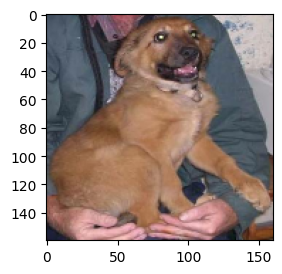

In [19]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")